In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA


## Data Preparation

### Data Loading

In [2]:
#load df_windows
df_windows = pd.read_csv('../data/df_windows.csv')
df_windows1 = pd.read_csv('../data/df_windows_1.csv')
df_windows0 = pd.read_csv('../data/df_windows_0.csv')
df_windows_2 = pd.read_csv('../data/df_windows_2.csv')

print(f"Number of events : Number of events : {len(df_windows)}, Number of No event : {len(df_windows0)}, Number of Minor events : {len(df_windows1)}, Number of Major events : {len(df_windows_2)}")

Number of events : Number of events : 899, Number of No event : 642, Number of Minor events : 207, Number of Major events : 50


In [3]:
#drop column IPLA, Distances, Shot, window, time_window
data = df_windows.drop(columns=['IPLA','ECEcore','ZMAG','LI', 'distances', 'window', 'time_window'])
data = data.drop(columns=['instability_x_current'])

validation_shot = 95467
#create data_val that takes the 1 validation shot
data_val = data[data['shot'] == validation_shot]

#take the shot out of data
data = data[data['shot'] != validation_shot]

data.head(5)


,distance_mean,minor_events,ECEcore_mean,ECEcore_dx1,ECEcore_dx2,ZMAG_mean,LI_mean,fft_low,shot,label,...,IPLA_ddx,IPLA_1,IPLA_2,IPLA_3,IPLA_4,IPLA_mean,Vloop_1,Vloop_2,Vloop_3,Vloop_4
0,-56307.483333,0.0,2822.7430,6.463867,-0.354248,0.342851,1.150685,2.885532e+07,81206,0,...,-2330.6250,1922563.1,1924126.80,1922741.80,1923580.8,1923687.9,-1.036661,-2.111309,-1.613139,-0.717432
1,-47580.700000,0.0,1955.4099,14.115967,-14.139160,0.355247,1.253791,2.927879e+07,81206,0,...,-3192.1250,1951248.2,1952237.00,1952226.20,1950999.0,1951919.2,-3.662136,-1.286469,-1.223850,-1.472519
2,-10166.108333,0.0,1770.3937,11.359497,4.013428,0.303880,1.191489,2.984001e+07,81206,0,...,1529.2500,1988619.6,1987009.50,1989410.00,1989018.2,1989334.0,-0.956687,-0.584253,-1.086478,-0.400202
3,-30771.841667,0.0,1824.6714,16.383667,0.000000,0.256757,1.147373,2.953092e+07,81206,0,...,-56.6250,1969271.8,1968408.60,1969010.90,1967915.2,1968728.4,-0.877379,-0.743979,-0.696189,-1.513505
4,64155.254167,0.0,1735.4666,0.000000,0.000000,0.197556,1.834007,9.361791e+06,81206,0,...,-5759.1875,622110.1,623452.44,624908.25,624267.8,624119.3,1.871721,1.500065,0.527328,0.995674


In [5]:
# Create a df X which contains all data columns except for the Label and shot column
X = data.drop(columns=['label','shot'])

# Create a df y which contains only the label column
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random Forest

### Trial run

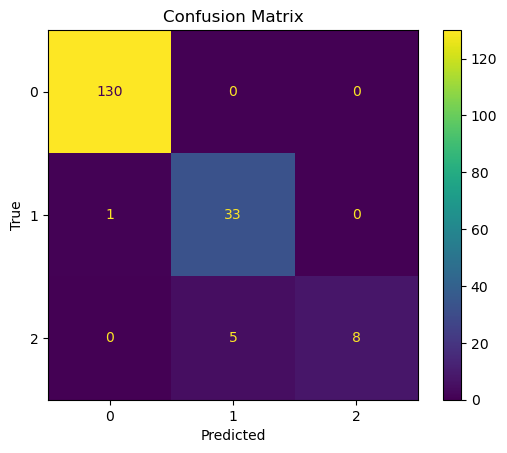

Accuracy: 0.9661016949152542
F1 score: 0.9636912106228294


In [6]:
# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

# Fit the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the ConfusionMatrixDisplay object and plot the confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

# Set the title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Show the plot
plt.show()
# Calculate accuracy to evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1_score(y_test, y_pred, average='weighted')}")

The model performs even better than Linear SVM without hyperparameter tuning, we thus investigate further.

### RF hyperparameter tuning

ATTENTION : This cell takes a long time to run (>20mins)

In [7]:
# Split the dataset into training and testing sets (we'll use Stratified K-Fold for cross-validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50,100,500,1000],  # Number of trees in the forest
    'max_depth': [10,50],  # Maximum depth of the trees
    'min_samples_split': [ 2,5,10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1,3,5]  # Minimum number of samples required to be at a leaf node

}

# Create a Stratified K-Fold cross-validator (you can adjust the number of folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', cv=cv)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and estimator
best_rf_classifier = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best classifier on the entire training data
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate accuracy to evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1_score(y_test, y_pred, average='weighted')}")
print("Best Hyperparameters:", best_params)


Accuracy: 0.9661016949152542
F1 score: 0.9636912106228294
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


Accuracy: 0.9423076923076923
F1 score: 0.9411288402000475
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

The following cell is just to output a training graph, it does not contribute to the model.

In [ ]:
# Split the dataset into training and testing sets (we'll use Stratified K-Fold for cross-validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42, min_samples_leaf=1, min_samples_split=2)

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10,50,100,200,400,500,600,800,1000],  # Number of trees in the forest
    'max_depth': [2,6,10,14,18],  # Maximum depth of the trees
    #'min_samples_split': [ 2,5,10],  # Minimum samples required to split an internal node
    #'min_samples_leaf': [1,3,5]  # Minimum number of samples required to be at a leaf node
    #'n_estimators': [500],  # Number of trees in the forest
    #'max_depth': [10],  # Maximum depth of the trees
    #'min_samples_split': [ 2],  # Minimum samples required to split an internal node
    #'min_samples_leaf': [1]  # Minimum number of samples required to be at a leaf node
}

# Create a Stratified K-Fold cross-validator (you can adjust the number of folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', cv=cv)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and estimator
best_rf_classifier = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best classifier on the entire training data
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate accuracy to evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1_score(y_test, y_pred, average='weighted')}")
print("Best Hyperparameters:", best_params)


Accuracy: 0.9661016949152542
F1 score: 0.9636912106228294
Best Hyperparameters: {'max_depth': 10, 'n_estimators': 200}


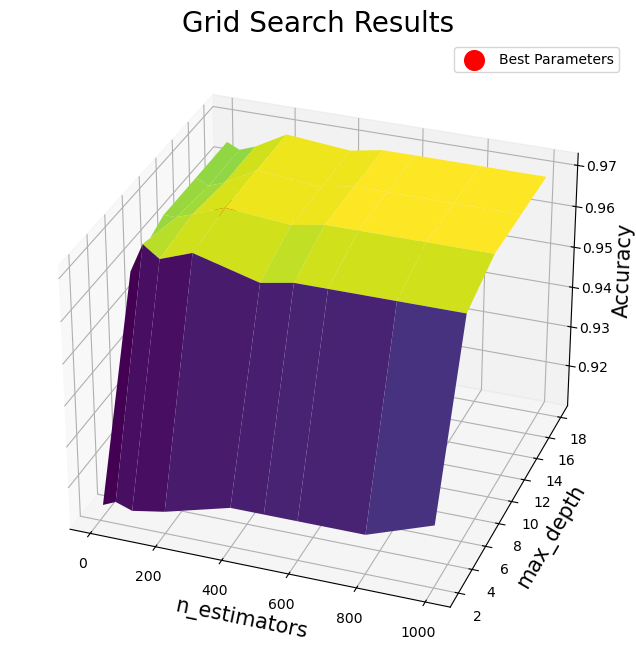

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# Get the grid search results
results = grid_search.cv_results_
param_grid = grid_search.param_grid

# Extract the hyperparameters and scores
n_estimators = param_grid['n_estimators']
max_depth = param_grid['max_depth']
scores = results['mean_test_score']

# Create a meshgrid for the hyperparameters
n_estimators_mesh, max_depth_mesh = np.meshgrid(n_estimators, max_depth)

# Reshape the scores to match the meshgrid shape
scores_mesh = scores.reshape(max_depth_mesh.shape)
# Create a 3D plot with a larger figure size
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(n_estimators_mesh, max_depth_mesh, scores_mesh, cmap='viridis')

# Get the best hyperparameters
best_params = grid_search.best_params_
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_score = grid_search.best_score_

# Plot the point for the best parameters
ax.scatter(best_n_estimators, best_max_depth, best_score, color='red', s=200, label='Best Parameters')

# Set labels and title with increased fontsize
ax.set_xlabel('n_estimators', fontsize=15)
ax.set_ylabel('max_depth', fontsize=15)
ax.set_zlabel('Accuracy', fontsize=15)
ax.set_title('Grid Search Results', fontsize=20)

# Increase fontsize of tick labels
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)
ax.view_init(azim=290)


# Add a legend
ax.legend()

# Show the plot
plt.show()
#plt.savefig('../figures/gridsearch_RF.png')

### Best RF model

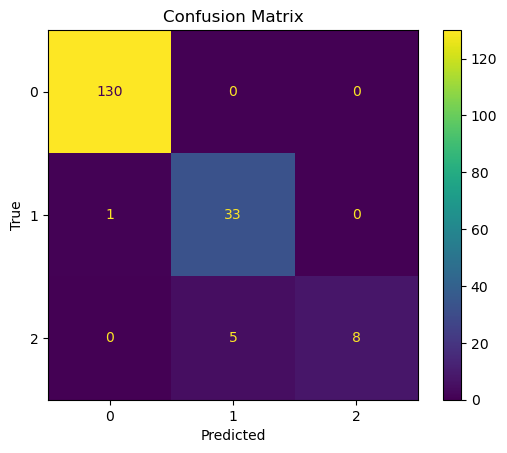

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       130
           1       0.87      0.97      0.92        34
           2       1.00      0.62      0.76        13

    accuracy                           0.97       177
   macro avg       0.95      0.86      0.89       177
weighted avg       0.97      0.97      0.96       177

ACCURACY : 0.9661016949152542
F1 SCORE 0.9636912106228294


In [8]:
#using the Best Hyperparameters for RF

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=42,max_depth=10,min_samples_leaf=1,min_samples_split=2)

# Fit the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the ConfusionMatrixDisplay object and plot the confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

# Set the title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Show the plot
plt.show()

print(classification_report(y_test, y_pred))
print(f"ACCURACY : {metrics.accuracy_score(y_test, y_pred)}")
print(f"F1 SCORE {metrics.f1_score(y_test, y_pred,average='weighted')}")


### Feature importance

Feature ranking:
1. minor_events (0.2287037200012757)
2. Vloop_3 (0.11439102194126326)
3. Vloop_2 (0.10617698833893911)
4. Vloop_1 (0.09057288172645682)
5. Vloop_4 (0.08977506052701316)
6. IPLA_dx3 (0.06997746064403766)
7. ECEcore_mean (0.05383718661780817)
8. IPLA_dx2 (0.02987741418650716)
9. IPLA_dx1 (0.029507107786116267)
10. IPLA_ddx (0.02686198341380405)
11. ZMAG_mean (0.026461386349248064)
12. distance_mean (0.019766920663909726)
13. ECEcore_dx2 (0.019725547978440502)
14. LI_mean (0.018213422080463063)
15. ECEcore_dx1 (0.017041382328688747)
16. IPLA_1 (0.011921048383843948)
17. IPLA_2 (0.010507417634561861)
18. IPLA_3 (0.009879533482250237)
19. IPLA_4 (0.009527045094013364)
20. IPLA_mean (0.008982702440067719)
21. fft_low (0.008292768381291327)


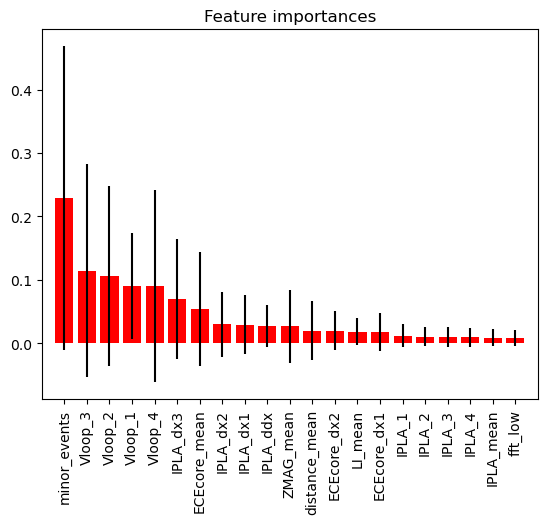

In [9]:
#plot the importance of the features
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f+1}. {X.columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color='r', yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


In [10]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X.columns)

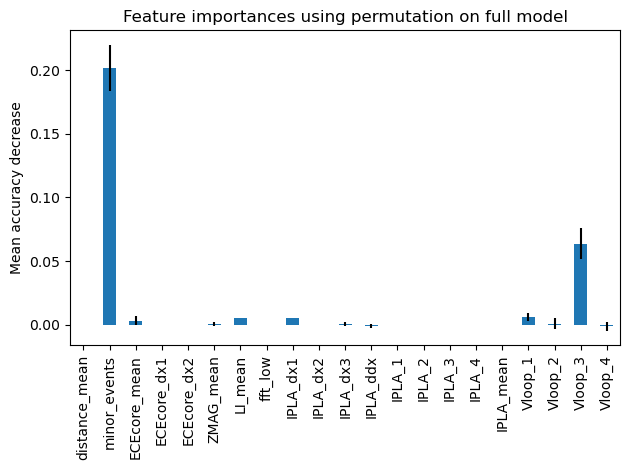

In [11]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Validation Shot

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.88      0.93         8
           2       1.00      1.00      1.00         2

    accuracy                           0.93        15
   macro avg       0.94      0.96      0.95        15
weighted avg       0.94      0.93      0.93        15

ACCURACY : 0.9333333333333333
F1 SCORE 0.9474747474747475


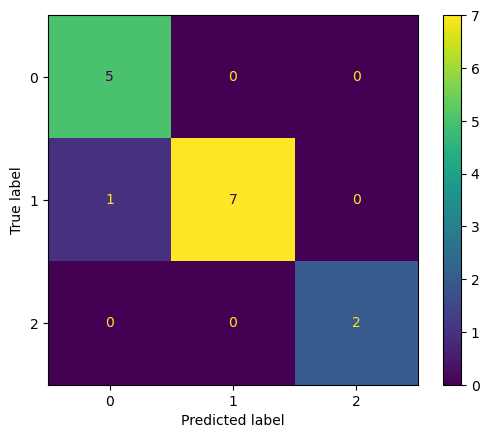

In [12]:
X_val = data_val.drop(columns=['label','shot'])
y_val = data_val['label']
y_pred = best_rf_classifier.predict(X_val)

print(classification_report(y_val, y_pred))
print(f"ACCURACY : {metrics.accuracy_score(y_val, y_pred)}")
print(f"F1 SCORE {metrics.f1_score(y_val, y_pred,average='macro')}")
# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create the ConfusionMatrixDisplay object and plot the confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
